### Cab-Driver Agent

<hr>
<font face = tahoma color = maroon>
Date: 17-Feb-2020 <br>
**Problem Statement**:<br>
RL-based algorithm which can help cab drivers maximise their profits by improving their decision-making process on the field.

**Architecture Chosen**:<br>
Considering the relatively low action space of max 16 actions (max 15 requests and 1 [0,0] action) with a relatively high state space (various combinations of location, time of the day and day of the week), we decided to go ahead with Architecture 1 which accepts only the <b>state as input.
</font>

<hr>
<b><font face = tahoma color = maroon>
    Importing Libraries
</font>    

In [20]:
# Importing libraries
import numpy as np
import random
import math
from collections import deque
import collections
import pickle
import time

# for building DQN model
from keras import layers
from keras import Sequential
from keras.layers import Dense, Activation, Flatten
from keras.optimizers import Adam

# for plotting graphs
import matplotlib.pyplot as plt

# Import the environment
from Env import CabDriver

# Loading the time matrix provided
Time_matrix = np.load("TM.npy")

### Q-Value Tracking: Initialisation

<hr>
<font face = tahoma color = maroon>
<b>Tracking the state-action pairs to check for convergence. Functions included: </b><br>
1. Initialise Q_dict and States_track <br>
2. Create function that helps convert the state tuple to string <br>
3. Define a function that will add new Q-values to the Q-dict <br>
4. Initialise States_track with sample states <br>
5. Define a function that will add new Q-values to the States_track <br>
</font>


In [21]:
# Initialise Q_dictionary as 'Q_dict' and States_tracked as 'States_track' (for convergence)

Q_dict = collections.defaultdict(dict)
States_track = collections.defaultdict(dict)
Rewards = collections.defaultdict(list)

In [22]:
def Q_state(state):
    return ('-'.join(str(e) for e in state))

In [23]:
# Defining a function which will add new Q-values to the Q-dictionary. 

def add_to_dict(state):
    state1 = Q_state(state)
    valid_act = env.action_space
    if state1 not in Q_dict.keys():
        for action in range(len(valid_act)):
            Q_dict[state1][action]=0.0

<hr><font face = tahoma color = maroon>
Note: <br>
Since the action value is in tuple as well. Instead of converting it into string, we have used the index value of the action with respect to the action space.
</font>

<hr><font face = tahoma color = maroon>
    Initialize Tracking States
</font>

In [24]:
def initialise_tracking_states():
  
    sample_q_values = [(('3-0-0'),0),
                      (('3-5-5'),3),
                      (('4-18-3'),10),
                      (('4-12-2'),15)]    #select any 4 Q-values
    for q_values in sample_q_values:
        state = q_values[0]
        action = q_values[1]
        States_track[state][action] = []    #this is an array which will have appended values of that state-action pair        

<hr><font face = tahoma color = maroon>
    Save Tracking States
</font>

In [25]:
def save_tracking_states():
    for state in States_track.keys():
        for action in States_track[state].keys():
            if state in Q_dict and action in Q_dict[state]:
                States_track[state][action].append(Q_dict[state][action])

<hr><font face = tahoma color = maroon>
    Save Q-Values in .pickle file
</font>

In [26]:
# Defining a function to save the Q-dictionary as a pickle file

def save_obj(obj, name ):
    with open(name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

In [27]:
initialise_tracking_states()

### Agent Class

<hr>
<font face = tahoma color = maroon>
If you are using this framework, you need to fill the following to complete the following code block:<br>
1. State and Action Size <br>
2. Hyperparameters <br>
3. Create a neural-network model in function 'build_model()' <br>
4. Define epsilon-greedy strategy in function 'get_action()' <br>
5. Complete the function 'append_sample()'. This function appends the recent experience tuple <state, action, reward, new-state> to the memory <br>
6. Complete the 'train_model()' function with following logic: <br>
   - If the memory size is greater than mini-batch size, you randomly sample experiences from memory as per the mini-batch size and do the following: <br>
      - Initialise your input and output batch for training the model <br>
      - Calculate the target Q value for each sample: reward + gamma*max(Q(s'a,)) <br>
      - Get Q(s', a) values from the last trained model <br>
      - Update the input batch as your encoded state and output batch as your Q-values <br>
      - Then fit your DQN model using the updated input and output batch. <br>
</font>

<hr><font face = tahoma color = maroon>
    Set Episodes, rewards per episode and env
</font>

In [28]:
# Episodes = 10000
Episodes = 2000

# initialise variables to track
rewards_per_episode, epsilon_value, loss = [], [], []

# 
env = CabDriver()
# state = env.state_init

<hr><font face = tahoma color = maroon>
Note: <br>
2 different methods were attempted for the epsilon greedy strategy.
1. Using the min-max strategy
2. Using the sample decay function provided at the end of the notebook

However, decided to move forward with method 2 since it helped increase the run time to some extent. 
Both the methods do allow the agent to **explore more during the initial episodes and gradually begin exploiting**.
</font>

In [29]:
class DQNAgent:
    def __init__(self, state_size, action_size):
        # Define size of state and action
        self.state_size = state_size
        self.action_size = action_size

        # Write here: Specify you hyper parameters for the DQN
        
        self.discount_factor = 0.95
        # self.discount_factor = GAMMA
        
        self.learning_rate = 0.01      
        # self.learning_rate = LR
        
        self.batch_size = 32
        # self.batch_size = batch_size
        
        # Initialise replay memory
        self.memory = deque(maxlen=2000)

        # Initialise model
        self.model = self.build_model()
        
        
    # approximate Q function using Neural Network
    def build_model(self):
        model = Sequential()
        # Write your code here: Add layers to your neural nets  
        
        input_shape = self.state_size

        model = Sequential()

        # hidden layers
        model.add(Dense(32, input_dim=self.state_size, activation='relu', kernel_initializer='he_uniform'))
        model.add(Dense(32, activation='relu', kernel_initializer='he_uniform'))

        # the output layer: output is of size num_actions
        model.add(Dense(self.action_size, activation='relu', kernel_initializer='he_uniform'))
        
        model.compile(loss='mse',optimizer=Adam(lr=self.learning_rate))
        model.summary
        return model

    
    def get_action_2(self, state,episode):
        
        # epsilon = 0 + (1 - 0) * np.exp(-0.0008*episode)
        # epsilon = 0 + (1 - 0) * np.exp(-0.008*episode) # for 1000 episodes
        
        epsilon = 0 + (1 - 0) * np.exp(-0.06*episode) 
        
        z = np.random.random()
        possible_actions = env.requests(state)
        
        epsilon_value.append(epsilon)

        if z > epsilon:
            #Exploration: choose a random action from the possible actions
            random_action = np.random.choice(len(possible_actions[1]))
            action = possible_actions[1][random_action]            
            return action
        else:
            #Exploit: choose the action with the max q-value
            #use the encoded state to get the model to predict the q-values of different actions
            state = env.state_encod_arch1(state) 
            state = state.reshape(1,state_size)
            q_value = self.model.predict(state)

            #Get the Q-values of the possible actions
            q_value = [q_value[0][position] for position in possible_actions[0]]
                        
            #Choose the max q-value from the possible actions
            max_action = np.argmax(q_value)
            
            #Get the corresponding action for the max q-value
            action = possible_actions[1][max_action]            
            return action
    
    # Append Sample to Memory (Replay Byffer)
    def append_sample(self, state, action, reward, next_state,done):
        # Write your code here:
        # save sample <s,a,r,s',done> to the replay memory
        next_state_append = np.copy(next_state)
        self.memory.append((state, action, reward, next_state_append,done))         

    # pick samples randomly from replay memory (with batch_size) and train the network
    def train_model(self):
                
        if len(self.memory) > self.batch_size:
            
            # Sample batch from the memory: Initialize the Network with Random Weights
            mini_batch = random.sample(self.memory, self.batch_size)
            update_output = np.zeros((self.batch_size, self.state_size))
            update_input = np.zeros((self.batch_size, self.state_size))
            actions, rewards,done = [], [], []
            
            for i in range(self.batch_size):
                state, action, reward, next_state, done_boolean = mini_batch[i]
                
                state_for_convergence = Q_state(state)
                
                # update input: adding the encoded input states
                update_input[i] = env.state_encod_arch1(state)
                update_input[i] = update_input[i].reshape(1,state_size)
                
                # update output: adding the encoded next states
                update_output[i] = env.state_encod_arch1(next_state)
                update_output[i] = update_output[i].reshape(1,state_size)
                
                # append actions, rewards, done
                actions.append(action)
                rewards.append(reward)
                done.append(done_boolean)
                
            # Write your code from here
            # 1. Predict the target from earlier model
            target = self.model.predict(update_input)

            # 2. Get the target for the Q-network
            target_qval = self.model.predict(update_output)

            # 3. Update your 'update_output' and 'update_input' batch. Be careful to use the encoded state-action pair
            for i in range(self.batch_size):
                #get the action index from the action space
                action_index = env.action_space.index(actions[i])
                if done[i]: #terminal state
                    target[i][action_index] = rewards[i]
                    Q_dict[state_for_convergence][action_index] = rewards[i]
                else: # non-terminal state
                    target[i][action_index] = rewards[i] + self.discount_factor * np.max(target_qval[i])
                    Q_dict[state_for_convergence][action_index] = rewards[i] + self.discount_factor * np.max(target_qval[i])


            # 4. Fit your model and track the loss values
            model_ = self.model.fit(update_input, target, batch_size=self.batch_size, epochs=1, verbose=0)
            loss.append(model_.history['loss'])

    def save(self, name):
        self.model.save(name)


### DQN block

In [30]:
start_time = time.time()
print('Start Time is :', time.ctime())

for episode in range(Episodes):

    # Write code here
    # Call the environment
    # Call all the initialised variables of the environment
    state_size = 36 #the length of the encoded state vector m+t+d
    action_size = len(env.action_space)
    done = False
    score = 0

    # reset at the start of each episode
    env.reset()
    state = env.state_init
    
    #Call the DQN agent
    agent = DQNAgent(action_size=action_size, state_size=state_size)

    
    while not done:
        
        # Write your code here
        # 1. Pick epsilon-greedy action from possible actions for the current state
        action = agent.get_action_2(state,episode)
        
        state_for_convergence = Q_state(state)
        add_to_dict(state_for_convergence)
        
        state_append = np.copy(state)
                
        # 2. Evaluate your reward and next state
        next_state, terminal_state, reward = env.next_state_func(state,action,Time_matrix)
                
        # 3. Append the experience to the memory
        agent.append_sample(state_append, action, reward, next_state,terminal_state)

        # 4. Train the model by calling function agent.train_model
        agent.train_model()

        # 5. Keep a track of rewards
        score += reward
        state = next_state
        done = terminal_state

    # every 1000 episodes :
    if episode in range(1500,Episodes,1500):
    # if episode in range(2000, Episodes, 2000):
        
        # print("episode {0}, reward {1}, memory_length {2}".format(episode,score,len(agent.memory)))
        elapsed_time = time.time() - start_time
        
        # print("Time Elapsed is minutes: {0}, Local_Time {1}".format((elapsed_time/60), time.ctime()))
        
        plt.figure(0, figsize=(6,2.5))
        rewards_per_episode
        plt.plot(np.arange(len(rewards_per_episode)), rewards_per_episode)
        plt.show()
    
    # every few episodes track Q_values, rewards and save model weights
    if episode % 10 == 0:
        # store q-values of some prespecified state-action pairs
        save_tracking_states()
        save_obj(States_track,'States_tracked') 
        Rewards[episode].append(score)
        save_obj(Rewards,'Rewards')
        
        # store total reward obtained every few episodes
        rewards_per_episode.append(score)

        # save model weights
        agent.save(name="model_weights.h5")
        

Start Time is : Mon Feb 17 23:52:34 2020


### Epsilon Curve
<hr>
<font face = tahoma color = maroon>
The gradual decline clearly shows that for the first few episodes it was more open to exploration following which it the agent moved on to exploitation
</font>

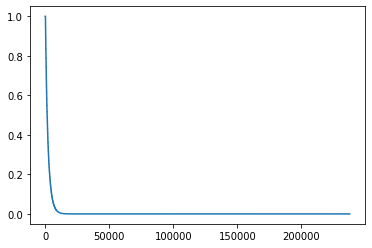

In [12]:
#Plot the epsilon curve
plt.plot(np.arange(len(epsilon_value)), epsilon_value)
plt.show()

In [ ]:
# print(loss)

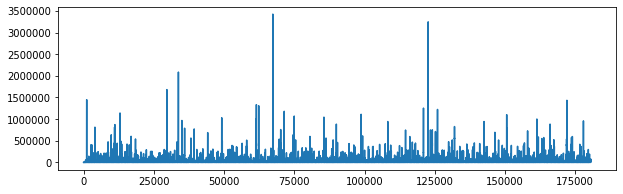

In [13]:
plt.figure(0, figsize=(10,3))
plt.plot(np.arange(len(loss)), loss)
plt.show()

### Convergence Graph for Rewards

<hr>
<font face = tahoma color = maroon>
The graph shows a gradual stability in rewards across the episodes. You can see a high variance at the begin which gradually ends up stabilising
</font>

In [14]:
# reading the tracked Q-values
infile = open('Rewards.pkl','rb')
rewards = pickle.load(infile)

In [15]:
rewards_per_episode
plt.figure(0, figsize=(10,3))
plt.plot(np.arange(len(rewards_per_episode)), rewards_per_episode)
plt.show()


### Convergence Graph for Q-values

In [16]:
# reading the tracked Q-values
infile = open('States_tracked.pkl','rb')
new_dict = pickle.load(infile)

# new_dict

In [ ]:
# State that the agent thinks is the best

# States_track

# max(Q_dict['3-0-0'],key=Q_dict['3-0-0'].get)
# max(Q_dict['3-5-5'],key=Q_dict['3-5-5'].get)
# max(Q_dict['4-18-3'],key=Q_dict['4-18-3'].get)
# max(Q_dict['4-12-2'],key=Q_dict['4-12-2'].get)

In [17]:
plt.figure(0, figsize=(16,6))

# sample_q_values = [('x-2-x-x-1-x-x-x-x',(8,5)), ('4-x-x-x-1-x-x-x-x',(2,8)), ('x-x-x-1-x-x-x-x-6',(3,5)),
#                        ('x-x-x-x-x-x-x-x-x',(6,1)), ('x-x-x-x-x-x-x-x-x',(7,3)), ('4-x-x-7-x-x-x-x-x',(1,1))]

xaxis = np.asarray(range(0, len(States_track['3-0-0'][0])))
plt.subplot(221)
plt.plot(xaxis,np.asarray(States_track['3-0-0'][0]))
# plt.show

xaxis = np.asarray(range(0, len(States_track['3-5-5'][3])))
plt.subplot(222)
plt.plot(xaxis,np.asarray(States_track['3-5-5'][3]))
# plt.show

xaxis = np.asarray(range(0, len(States_track['4-18-3'][10])))
plt.subplot(223)
plt.plot(xaxis,np.asarray(States_track['4-18-3'][10]))
# plt.show

xaxis = np.asarray(range(0, len(States_track['4-12-2'][15])))
plt.subplot(224)
plt.plot(xaxis,np.asarray(States_track['4-12-2'][(15)]))

plt.show

<function matplotlib.pyplot.show(*args, **kw)>

### Epsilon-decay sample function

<div class="alert alert-block alert-info">
Try building a similar epsilon-decay function for your model.
</div>

In [18]:
time = np.arange(0,10000)
epsilon = []
for i in range(0,10000):
    epsilon.append(0 + (1 - 0) * np.exp(-0.0009*i))

In [19]:
plt.plot(time, epsilon)
plt.show()